# 基于TextCNN实现客服问题分类

## 1. 问题定义

### 1.1 项目背景

本人所在企业拥有庞大的客服团队，每天需要处理5000+客户的各种问题。如何提高客服团队的工作效率、提升客服的工作品质，为客户提供快速、及时、专业、到位的服务，成为公司提升客户服务体验，增进业务数据，树立市场口碑，建立行业壁垒的重要课题。

客服团队的传统管理哲学主要靠3大核心体系：**培训**、**激励**、**质检**。在互联网时代，尤其是人工智能时代，传统的管理思想已经明显落后且生产力低下，主要体现在：

* 培训需要投入大量培训资源，客服人员成熟时间周期长；
* 激励往往只画饼、定目标，很少提供达成目标的工具；
* 质检同样需要投入大量人力，且纠偏不及时，属于亡羊补牢。

现代客服团队管理强调的是--**标准化**。

通过将客服问题标准化，降低培训的难度和客服人员成熟的周期；标准化后，可以为客服人员提供更加便捷高效的客服工具，提升工作效能；有了标准化的客服话术，质检也可以实现自动化，更加实时有效，且节省人力。

因此，一套基于业务场景的客服问题知识图谱是提升企业客服品效的核心。公司希望利用人工智能为客服团队打造一套智能辅助系统，在理解客户问题的基础上，为客服人员推荐回应话术。

### 1.2 问题描述

实现智能客服的前提是首先理解客户的问题，然后根据客户所问的问题在知识库或知识图谱中匹配回应内容。所以如何准确理解客户问题是实现智能客服的核心。

公司的客服知识库是基于客户的问题类型进行分类组织的，经过2年的沉淀，已经形成了【知识类目和条数】。之前对客户问题的分类采用的是粗暴的关键字发现，从客户的问题中提取关键字，然后去匹配问题类型。（流程见图1）

![](.\img\p1.png)
<center>图1：基于关键词匹配的问题响应流程</center>

上面流程最大的问题在红框标出的部分。

**首先**，关键词往往不能反映客户问题的本意。汉语博大精深，相同词汇组成的句子如果结构或标点符号不同，意思可能大相径庭。比如：

> 健康告知没有了，限制就没意义了。
>
> 健康告知没有了限制，就没意义了。

这两个句子里的文字完全一样，但标点符号不同，表达的意思截然相反。这种情况，通过关键字无法准确识别客户的真实意图，造成回复驴唇不对马嘴。

**其次**，客户的同一问题表达方式会多种多样，提取的关键词也会非常多变，系统不可能穷尽所有关键词情况。比如客户问：

> 我是美国人，我可以投保吗？
>
> 我是汤加人，我可以投保吗？

其实这两个问题是同一类问题，但是提取的关键字第一个是`美国`，第二个是`汤加`。如果系统没有对`汤加`做处理，则对第二个问题就没办法很好的回答。

**最后**，关键词匹配丢失了上下文，对于客户的连续问题无法很好的处理。比如：

> 我36岁，可以投保这个产品吗？
>
> 那我爸爸呢？

对第二个问题，只能提取到`爸爸`一个关键词，系统完全不知如何回应。

尽管可以通过很多算法和技巧优化上面的问题，但是整体在实际应用中，匹配准确率只有**47%**，无法满足商业应用的要求。理想的解决方案就是利用人工智能，让机器真的能够理解客户问题的语义，然后根据对问题语义进行分类，从而提高匹配的准确率。理想中的流程如下图：

![](.\img\p2.png)
<center>图2：基于语义理解的问题响应流程</center>

新旧流程的区别就在绿框部分，需要训练一个模型能够理解用户输入文本的语义，并将其分类到一个问题分类上。本文下面的内容将围绕这个问题，利用公司已经标记好的客服问题数据集，采用深度学习的方法，训练一个客服问题分类模型。

### 1.3 评估指标

本项目的目的是将用户提问的问题准确的匹配到一个问题分类上，所以模型的评估指标是**分类的准确率**，即：分类正确的样本数/样本总数
$$
Acc = \frac{N_{correct}}{N_{total}}
$$
旧有的基于关键词匹配的准确率只有**47%**，为了满足商业应用需要，期望技术深度学习训练出的模型在测试集和验证集上的准确率都能在**90%**以上。

由于训练结果要用于商业使用上，所以还需要考虑性能和部署，希望训练好的模型对客户问题的识别耗时<1s；为了满足规模使用，应对客户问题峰值，整个解决方案需要支持迁移学习和分布式部署。

## 2. 问题分析

### 2.1 数据集获取

本文以公司积累的客服问题为研究对象。目前公司数据库中积累的客服问题有3万多条，剔除一些类似“你好”，“在吗？”等字数不超过5个字的问题，还剩下18000多条，从中取16890条作为数据集。

由于这些数据存储在公司服务器，为了便于数据获取和分析，经公司同意，将这批数据脱敏后下载到我个人服务器，保存在MongoDB数据库中。可以通入如下代码获取数据：

In [1]:
import numpy as np
import pandas as pd
import pymongo

# 连接mongodb数据库
mongo_client = pymongo.MongoClient("mongodb://112.74.93.48:27017/")
db = mongo_client["InsuranceQA"]
col = db["question"]

# 从数据库导入数据到dataframe
df = pd.DataFrame(list(col.find({},{ "no": 1, "question": 1, "type": 1, "_id": 0  } )))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16890 entries, 0 to 16889
Data columns (total 3 columns):
no          16890 non-null float64
question    16890 non-null object
type        16890 non-null object
dtypes: float64(1), object(2)
memory usage: 395.9+ KB


### 2.2 数据探索

#### 2.2.1 整体描述

将数据从MongoDB读入Pandas，对数据进行简单的探索。从输出可以看出数据集中共有**16888**条数据，每条数据有3个字段，字段描述如下：

| 字段名   | 类型   | 说明                          |
| -------- | ------ | ----------------------------- |
| no       | int    | 问题的编号，从0开始，顺序编号 |
| question | string | 客服问题                      |
| type     | string | 问题类型                      |

#### 2.2.2 对`type`的统计描述

我们要解决的问题是希望对问题进行分类，即建立从`question`到`type`的映射，所以需要关注有多少种分类。

In [2]:
df_groupby_type = df.groupby(["type"]).count()
df_groupby_type["rate(%)"] = df_groupby_type["question"]*100/df_groupby_type["question"].sum()# 计算各分类占比
df_groupby_type[["question", "rate(%)"]]

,question,rate(%)
type,,
伤残险,949,5.618709
健康险,2002,11.853168
其他,36,0.213144
养老险,525,3.108348
医疗险,2301,13.623446
家财险,1751,10.367081
寿险,4371,25.879218
年金险,800,4.736530
租赁险,1086,6.429840


从输出结果中看出，所有问题分成了13类，各分类占比如下：

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
plt.rcParams['font.sans-serif'] = ['SimHei'] # 解决中文显示问题
plt.rcParams['font.serif'] = ['SimHei'] # 解决中文显示问题
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(18, 6))
plt.bar(df_groupby_type.index, df_groupby_type['question'])
plt.show()

<Figure size 1800x600 with 1 Axes>

从分类占比上可以看出，我们日常常见的寿险、健康险、医疗险和车险占比最大。

#### 2.2.3 对`question`的统计描述

In [4]:
df["q_len"] = df["question"].str.len()
df['q_len'].describe()

count    16890.000000
mean        13.043635
std          3.729618
min          5.000000
25%         11.000000
50%         13.000000
75%         15.000000
max         78.000000
Name: q_len, dtype: float64

从输出可以看出问题字数都不长，平均13个字（含标点）。最长问题78个字，最短的2个字。分布如下图：

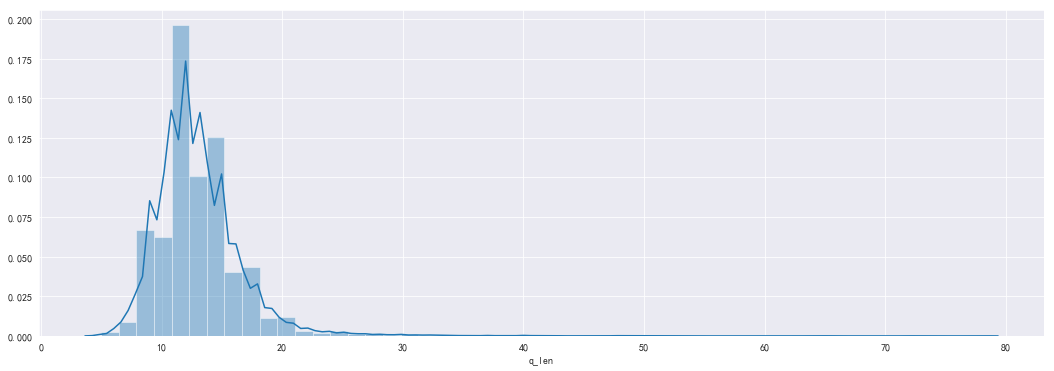

In [5]:
plt.figure(figsize=(18, 6))
sns.distplot(df["q_len"])
plt.show()

从分布上可以看出问题字数主要集中在8-18各字，其中以12个字的问题最多。文字字数少正向的一面是训练所需的时间会比较少，不利的一面是由于提供的信息有限，在分类任务中可能无法很好的泛化出有效的模型。所以算法选择就更为重要。

### 2.3 算法选型

文本分类有很多的实现算法，从大类划分有2大类：

* 基于传统机器学习的文本分类，如SVM、朴素贝叶斯等
* 基于深度学习的文本分类，如TextCNN, LSTM...

#### 2.3.1 传统机器学习方法

传统机器学习方法是90年代后期，伴随着统计学习方法的发展和互联网的兴起，发展起来的经典机器学习方法。传统机器学习方法解决问题的思路是**人工特征工程**+**浅层的分类模型**。就文本分类问题而言，整个过程分解为特征提取和分类器构建两部分（见图3）。

![](./img/p5.png)

<center>图5：传统机器学习方法解决文本分类流程</center>

#### 2.3.2 深度学习方法

传统机器学习方法主要问题的文本表示是高维度高稀疏的，特征表达能力很弱，而且神经网络很不擅长对此类数据的处理；此外人工特征工程需要人工介入，成本很高。近几年随着深度学习的发展，深度学习算法在文本表示和特征表达方面取得了巨大突破。2014年，Yoon Kim针对CNN的输入层做了一些变形，提出了文本分类模型TextCNN，利用CNN提取文本的特征，去掉繁杂的人工特征工程，最后根据特征进行分类，取得了良好的效果。

![](./img/p6.png)

<center>图6：深度学习方法解决文本分类流程</center>

#### 2.3.3 算法选择

通过上面的介绍，我们可以发现深度学习方法比传统机器学习方法具有明显优势。

**首先**，深度学习方法不需要人工手动的提取文本的特征，它可以自动的获取基础特征并组合为高级的特征，训练模型获得文本特征与目标分类之间的关系，省去了使用TF-IDF等提取句子的关键词构建特征工程的过程。

**其次**，由于我们的问题字数比较少，如果采用传统方法单纯通过词特征来分类可能无法很好的完成分类任务；相比传统模型而言，深度学习可以更好的利用词序的特征。

**最后**，考虑训练效率和最终上线部署实施，深度学习方法比传统方法具有优势。利用Tensorflow框架可以利用GPU加速训练过程，并且训练出的模型更容易分布式部署。

而TextCNN相对于其他网络有如下优势：

1. **网络结构简单**，却依旧有很不错的效果；
2. **参数数目少, 计算量少, 训练速度快**

综上，在模型算法上采用深度学习方法，利用TextCNN进行文本分类；实现上使用Tensorflow开发和部署。

## 3. 模型实现

本模型的实现参考了**Yoon Kim**的论文[(2014 EMNLP) Convolutional Neural Networks for Sentence Classification](https://arxiv.org/abs/1408.5882)，论文中Yoon Kim的TextCNN结构可以描述为下图的网络：

![](.\img\p7.png)

<center>图7：TextCNN网络结构</center>

TextCNN的实现过程可以分为图下4步：

- **Embedding**：第一层是图中最左边的句子矩阵，每行是词向量，这个可以类比为图像中的原始像素点。
- **Convolution**：然后经过一维卷积层，每个kernel_size 有两个输出 channel。
- **MaxPolling**：第三层是一个1-max pooling层，这样不同长度句子经过pooling层之后都能变成定长的表示。
- **FullConnection and Softmax**：最后接一层全连接的 softmax 层，输出每个类别的概率。

### 3.1 数据预处理

原始的文本数无法直接在CNN中使用，所以在训练模型前，首先需要对数据进行预处理并将其转化为CNN能用的格式。整个数据预处理分为如下几步：

![](.\img\p8.png)

<center>图8：数据预处理步骤</center>

#### 3.1.1 分词并统计词频

分词采用结巴分词对中文进行分词。分词前先做去标点符号处理，然后再分词，接着去掉停用词，统计词频。

In [6]:
import jieba
import string

trantab = str.maketrans({key: None for key in string.punctuation+'？，。'+string.digits})
word_dict = {'<PAD>': 0}

# 加载去停用词表
stopword = open('./stopwords.txt', 'r', encoding='utf-8')
stop = [key.strip(' \n') for key in stopword]

# 判断是否是停用词
def is_stop_word(word):
    return (word == '') or (word in stop)

# 对问题进行分词，并统计词频
def word_split(question):
    question = question.translate(trantab)# 去标点符号和数字
    word_list = jieba.lcut(question)# 用结巴分词进行中文分词
    word_content = ''
    for word in word_list:
        word = word.strip(' ')
        if not is_stop_word(word):
            word_content += word + ' '
            word_dict.setdefault(word, 0) # 如果这个词第一次出现，就把给词语的默认值设为0
            word_dict[word] += 1
    return word_content

df['fenci'] = df.apply(lambda row: word_split(row['question']), axis=1)
df.head(5)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\jarod\AppData\Local\Temp\jieba.cache
Loading model cost 1.526 seconds.
Prefix dict has been built successfully.


,no,question,type,q_len,fenci
0,0.0,法律要求残疾保险吗？,伤残险,10,法律 残疾 保险
1,1.0,债权人可以在死后人寿保险吗？,寿险,14,债权人 死 人寿保险
2,2.0,旅行者保险有租赁保险吗？,租赁险,12,旅行者 保险 租赁 保险
3,3.0,我可以开一辆没有保险的新车吗？,车险,15,开 一辆 保险 新车
4,4.0,人寿保险的现金转出价值是否应纳税？,寿险,17,人寿保险 现金 转 价值 应 纳税


#### 3.1.2 生成词汇表

根据上面的字典，生成word-to-id的映射表。

In [7]:
word_df = pd.DataFrame(zip(word_dict.keys(), word_dict.values()))
word_df.rename(columns={0:'word', 1:'freq'}, inplace = True)
word_df.head(5)

,word,freq
0,<PAD>,0
1,法律,27
2,残疾,912
3,保险,6561
4,债权人,43


其中用data frame的index作为id，word是词，freq是词频。

用同样的方法生成分类的映射表

In [19]:
type_df = pd.DataFrame(zip(df_groupby_type.index,df_groupby_type['question']))
type_df.rename(columns={0:'type', 1:'freq'}, inplace = True)
type_df.head(20)

,type,freq
0,伤残险,949
1,健康险,2002
2,其他,36
3,养老险,525
4,医疗险,2301
5,家财险,1751
6,寿险,4371
7,年金险,800
8,租赁险,1086
9,车险,2165


同样用data frame的index作为id，type是类型，freq是频率。

#### 3.1.3 数据集划分 

采用**8:1:1**的比例将数据集划分为训练集、测试集和验证集。

In [9]:
# 将数据按照8:1:1的比例划分为训练集、测试集和验证集
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(df['fenci'], df['type'], test_size=0.20, random_state=1018)
X_test, X_valid, Y_test, Y_valid = train_test_split(X_test, Y_test, test_size=0.50, random_state=1018)
print("训练集：%d\n测试集：%d\n验证集：%d" % (X_train.count(), X_test.count(), X_valid.count()))

训练集：13512
测试集：1689
验证集：1689


#### 3.1.4 数据向量化

目前数据集中的数据还是分词后的文本，我们需要根据第2步构建的字典将问题和分类进行向量化处理。处理过程很简单，就是查字典的过程，需要注意的是由于问题长度不通过，分词出来的个数不同，为了LSTM能够使用，需要做阶段或补齐。根据数据探索部分对问题长度的统计，问题都不长，平均13个字（含标点），这里将分词个数设置为10个。最后将数据转化为numpy格式，这样数据准备工作就完成了。

In [10]:
import tensorflow as tf

word_num = 10 # 词数，用于截断或补齐

# 查词汇表，得到词id
def word2id(word):
    result = word_df[word_df["word"] == word].index.values
    if len(result)>0:
        return result[0]
    else:
        return 0
    
# 查分类表，得到分类id
def type2id(word):
    result = type_df[type_df["type"] == word].index.values
    if len(result)>0:
        return result[0]
    else:
        return 2
    
# 将文字转换为向量，使其可以再LSTM网络中使用
def word2vector(X, Y):
    x_id = []
    y_id = []
    for x ,y in zip(X, Y):
        word_ids = [word2id(word) for word in x.split(' ')]
        type_ids = type2id(y)
        x_id.append(word_ids)
        y_id.append(type_ids)
    # 转变为 numpy 类型
    #x = np.asarray(x_id, dtype=np.int32)
    #y = np.asarray(y_id, dtype=np.int32)
    x_pad = tf.keras.preprocessing.sequence.pad_sequences(x_id, word_num, padding='post',truncating='post',value = 0)  # 用0补齐
    y_pad = tf.keras.utils.to_categorical(y_id, num_classes=type_df["type"].count())  # 将标签转换为one-hot表示
    return x_pad, y_pad

In [11]:
train_input, train_output = word2vector(X_train, Y_train)
test_input , test_output  = word2vector(X_test , Y_test)
valid_input, valid_output = word2vector(X_valid, Y_valid)

### 3.2 TextCNN模型实现

实际实现过程中采用了如下的结构:

![](.\img\p11.png)

<center>图9：实际实现的TextCNN网络结构</center>

代码实现如下：

In [12]:
seq_length = 10     # 序列长度
num_classes = type_df['type'].count() # 类别数
vocab_size = word_df['word'].count()  # 词汇表达小
embedding_dim = 64  # 词向量维度
num_filters = 256  # 卷积核数目
kernel_size = 5  # 卷积核尺寸
hidden_dim = 256  # 全连接层神经元

learning_rate = 0.001  # 学习率
batch_size = 64  # 每批训练大小
num_epochs = 10  # 总迭代轮次
dropout_keep_prob = 0.5  # dropout保留比例
print_per_batch = 100  # 每多少轮输出一次结果
save_per_batch = 10  # 每多少轮存入tensorboard

In [13]:
input_x = tf.placeholder(tf.int32, [None, seq_length], name='input_x')
input_y = tf.placeholder(tf.float32, [None, num_classes], name='input_y')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

# 词向量映射
embedding = tf.get_variable('embedding', [vocab_size, embedding_dim])
embedding_inputs = tf.nn.embedding_lookup(embedding, input_x)

# CNN层
conv = tf.layers.conv1d(embedding_inputs, num_filters, kernel_size, name='conv')
# global max pooling层
gmp = tf.reduce_max(conv, reduction_indices=[1], name='gmp')

# 全连接层，后面接dropout以及relu激活
fc = tf.layers.dense(gmp, hidden_dim, name='fc1')
fc = tf.contrib.layers.dropout(fc, keep_prob)
fc = tf.nn.relu(fc)

# 分类器
logits = tf.layers.dense(fc, num_classes, name='fc2')
y_pred_cls = tf.argmax(tf.nn.softmax(logits), 1)  # 预测类别


# 损失函数，交叉熵
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=input_y)
loss = tf.reduce_mean(cross_entropy)

# 优化器
optim = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

# 准确率
correct_pred = tf.equal(tf.argmax(input_y, 1), y_pred_cls)
acc = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use `tf.keras.layers.Conv1D` instead.
Instructions for updating:
Use keras.layers.dense instead.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [14]:
import os

# 配置tensorboard
tensorboard_dir = 'tensorboard'
if not os.path.exists(tensorboard_dir):
    os.makedirs(tensorboard_dir)

tf.summary.scalar("loss", loss)
tf.summary.scalar("accuracy", acc)
merged_summary = tf.summary.merge_all()
writer = tf.summary.FileWriter(tensorboard_dir)

# 配置 Saver
saver = tf.train.Saver()
save_dir = 'checkpoints'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [15]:
total_batch = 0  # 总批次
best_acc_val = 0.0  # 最佳验证集准确率
last_improved = 0  # 记录上一次提升批次

session = tf.Session()
session.run(tf.global_variables_initializer())
writer.add_graph(session.graph)

def batch_iter(x, y, batch_size=64):
    """生成批次数据"""
    data_len = len(x)
    num_batch = int((data_len - 1) / batch_size) + 1

    indices = np.random.permutation(np.arange(data_len))
    x_shuffle = x[indices]
    y_shuffle = y[indices]

    for i in range(num_batch):
        start_id = i * batch_size
        end_id = min((i + 1) * batch_size, data_len)
        yield x_shuffle[start_id:end_id], y_shuffle[start_id:end_id]

def feed_data(x_batch, y_batch, prob):
    feed_dict = {
        input_x: x_batch,
        input_y: y_batch,
        keep_prob: prob
    }
    return feed_dict

def evaluate(sess, x_, y_):
    """评估在某一数据上的准确率和损失"""
    data_len = len(x_)
    batch_eval = batch_iter(x_, y_, 128)
    total_loss = 0.0
    total_acc = 0.0
    for x_batch, y_batch in batch_eval:
        batch_len = len(x_batch)
        feed_dict = feed_data(x_batch, y_batch, 1.0)
        tmp_loss, tmp_acc = sess.run([loss, acc], feed_dict=feed_dict)
        total_loss += tmp_loss * batch_len
        total_acc += tmp_acc * batch_len

    return total_loss / data_len, total_acc / data_len

for epoch in range(num_epochs):
    print('Epoch:', epoch + 1)
    batch_train = batch_iter(train_input, train_output, batch_size)
    for x_batch, y_batch in batch_train:
        feed_dict = feed_data(x_batch, y_batch, dropout_keep_prob)
        if total_batch % save_per_batch == 0:
            # 每多少轮次将训练结果写入tensorboard scalar
            s = session.run(merged_summary, feed_dict=feed_dict)
            writer.add_summary(s, total_batch)
                
        if total_batch % print_per_batch == 0:
            # 每多少轮次输出在训练集和验证集上的性能
            feed_dict[keep_prob] = 1.0
            loss_train, acc_train = session.run([loss, acc], feed_dict=feed_dict)
            loss_val, acc_val = evaluate(session, valid_input, valid_output)  # todo

            if acc_val > best_acc_val:
                # 保存最好结果
                best_acc_val = acc_val
                last_improved = total_batch
                saver.save(sess=session, save_path='checkpoints/best/')

            msg = 'Iter: {0:>6}, Train Loss: {1:>6.2}, Train Acc: {2:>7.2%}, Val Loss: {3:>6.2}, Val Acc: {4:>7.2%}'
            print(msg.format(total_batch, loss_train, acc_train, loss_val, acc_val))

        feed_dict[keep_prob] = dropout_keep_prob
        session.run(optim, feed_dict=feed_dict)  # 运行优化
        total_batch += 1

Epoch: 1
Iter:      0, Train Loss:    2.6, Train Acc:   6.25%, Val Loss:    2.6, Val Acc:   1.42%
Iter:    100, Train Loss:   0.47, Train Acc:  87.50%, Val Loss:   0.31, Val Acc:  92.78%
Iter:    200, Train Loss:   0.28, Train Acc:  92.19%, Val Loss:   0.15, Val Acc:  96.15%
Epoch: 2
Iter:    300, Train Loss:  0.099, Train Acc:  95.31%, Val Loss:   0.12, Val Acc:  96.74%
Iter:    400, Train Loss:  0.054, Train Acc:  98.44%, Val Loss:   0.11, Val Acc:  96.86%
Epoch: 3
Iter:    500, Train Loss:   0.12, Train Acc:  93.75%, Val Loss:   0.11, Val Acc:  96.98%
Iter:    600, Train Loss:  0.013, Train Acc: 100.00%, Val Loss:   0.11, Val Acc:  96.74%
Epoch: 4
Iter:    700, Train Loss:  0.055, Train Acc:  96.88%, Val Loss:   0.11, Val Acc:  96.39%
Iter:    800, Train Loss:   0.12, Train Acc:  96.88%, Val Loss:   0.11, Val Acc:  96.86%
Epoch: 5
Iter:    900, Train Loss:  0.037, Train Acc:  98.44%, Val Loss:   0.12, Val Acc:  96.86%
Iter:   1000, Train Loss:  0.026, Train Acc: 100.00%, Val Loss:  

从训练结果可以看出，100次迭代之后，验证集上的准确率就能达到90%，整个训练结束后，最好结果在验证集上准确率可以达到97.16%，相当不错。

![](.\img\tensorboard-acc.png)

<center>图10：准确率变化</center>

![](.\img\tensorboard_loss.png)

<center>图11：loss变化</center>

## 4. 模型效果

训练得到的最优模型保存在**./checkpoint/best**目录下，利用该模型在测试集上测试模型效果。

In [16]:
from sklearn import metrics

session = tf.Session()
session.run(tf.global_variables_initializer())
saver = tf.train.Saver()
saver.restore(sess=session, save_path='checkpoints/best/')  # 读取保存的模型


loss_test, acc_test = evaluate(session, test_input, test_output)
msg = 'Test Loss: {0:>6.2}, Test Acc: {1:>7.2%}'
print(msg.format(loss_test, acc_test))

batch_size = 128
data_len = len(test_input)
num_batch = int((data_len - 1) / batch_size) + 1

test_cls = np.argmax(test_output, 1)
pred_cls = np.zeros(shape=len(test_input), dtype=np.int32)  # 保存预测结果

# 分批运行
for i in range(num_batch): 
    start_id = i * batch_size
    end_id = min((i + 1) * batch_size, data_len)
    feed_dict = {
        input_x: test_input[start_id:end_id],
        keep_prob: 1.0
    }
    pred_cls[start_id:end_id] = session.run(y_pred_cls, feed_dict=feed_dict)

# 输出评估结果
print(metrics.classification_report(test_cls, pred_cls, target_names=type_df['type']))

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from checkpoints/best/
Test Loss:   0.13, Test Acc:  96.27%
              precision    recall  f1-score   support

         伤残险       0.98      0.99      0.98        89
         健康险       0.99      0.97      0.98       213
          其他       0.60      0.60      0.60         5
         养老险       0.69      0.84      0.76        62
         医疗险       1.00      0.98      0.99       208
         家财险       0.98      1.00      0.99       206
          寿险       0.99      0.99      0.99       406
         年金险       0.96      0.97      0.97        75
         租赁险       0.96      0.96      0.96       105
          车险       0.97      0.98      0.97       214
        退休计划       0.36      0.17      0.23        29
         重疾险       1.00      1.00      1.00        15
       长期护理险       1.00      0.98      0.99        62

   micro avg       0.96      0.96      0.96      1689
   m

In [17]:
# 输出混淆矩阵
cm = metrics.confusion_matrix(test_cls, pred_cls)
print(cm)

[[ 88   0   0   0   0   0   0   0   1   0   0   0   0]
 [  1 207   1   1   1   1   0   1   0   0   0   0   0]
 [  0   0   3   0   0   0   1   0   1   0   0   0   0]
 [  0   0   0  52   0   0   1   0   0   0   9   0   0]
 [  0   1   0   0 204   0   0   0   0   3   0   0   0]
 [  0   0   1   0   0 205   0   0   0   0   0   0   0]
 [  0   1   0   0   0   0 403   1   0   1   0   0   0]
 [  0   0   0   0   0   0   0  73   0   2   0   0   0]
 [  0   0   0   0   0   2   1   0 101   1   0   0   0]
 [  0   0   0   0   0   1   2   0   2 209   0   0   0]
 [  0   0   0  22   0   1   0   1   0   0   5   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  15   0]
 [  1   0   0   0   0   0   0   0   0   0   0   0  61]]


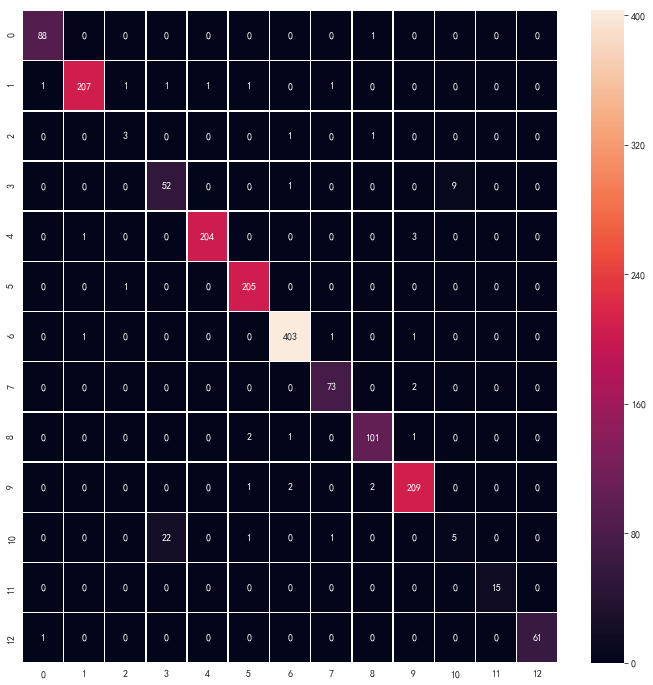

In [18]:
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5)
plt.show()

从输出可以看出，模型在测试集上准确率达到**96.45%**，这个结果还是令人满意的。

从各分类的准确率、召回率和F1-score上看，其他和养老险这2各分类准确率很低，需要进一步优化。

## 5. 结论

从验证和测试结果来看分类效果非常理想，能够达到项目的评估指标。

但是具体到各分类，**其他**和**养老险**这两个类别准确很低，其中**其他**的准确率只有33%。稍微研究了一下这两个分类的数，**其他**准确率的原因主要是数据量太少，模型没有很好的提取出问题特征。而养老险跟年金、医疗险和健康险的特征比较接近，没有很好的泛化。

后面会针对这两个分类做更深入的研究

1. 增加其他分类的数据样本
2. 采用RNN重写模型，验证RNN能否更好的解决养老险无法有效提取特征的问题。

## 参考文献

[1] Minwei Feng, Bing Xiang, Michael R. Glass, Lidan Wang, Bowen Zhou. APPLYING DEEP LEARNING TO ANSWER SELECTION: A STUDY AND AN OPEN TASK[cs.CL]. 2015

[2] Yoon Kim. Convolutional Neural Networks for Sentence Classification[cs.CL]. 2014

[3] 文本分类算法TextCNN原理详解. https://www.cnblogs.com/ylaoda/p/11339925.html

[4] Tensorflow使用LSTM实现中文文本分类. https://blog.csdn.net/missyougoon/article/details/89414953